# Домашнее задание 6

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_6

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию координатного спуска (смотри семинар). 

Для такого метода подберите шаг $\gamma$ для наилучшей сходимости постройте график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число арифмитических операций при подсчете "градиента"). Постройте на этом же графике сходимость честного градиентного спуска c наилучшим шагом сходимости. Сделайте вывод о характере сходимости нового метода.

In [7]:
import numpy as np 
import matplotlib.pyplot as plt 
import math  
import time 
from numpy import linalg   
import random  

In [8]:
random.seed(42) 

In [9]:
def rvs(dim=3):
     random_state = np.random
     H = np.eye(dim)
     D = np.ones((dim,))
     for n in range(1, dim):
         x = random_state.normal(size=(dim-n+1,))
         D[n-1] = np.sign(x[0])
         x[0] -= D[n-1]*np.sqrt((x*x).sum())
         # Householder transformation
         Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
         mat = np.eye(dim)
         mat[n-1:, n-1:] = Hx
         H = np.dot(H, mat)
     D[-1] = (-1)**(1-(dim % 2))*D.prod()
     H = (D*H.T).T
     return H
    
def generate_matrix(d, m, L):  
    A = np.eye(d) 
    A[0, 0] = L
    A[1, 1] = m
    S = rvs(d) 
    A = np.dot(np.linalg.inv(S), np.dot(A, S))
    return A 

In [10]:
b = np.random.normal(size=(100,)) 

In [11]:
class CoordinateDescent: 
    def __init__(self, b, max_iter = 10000, L = 1000, mu = 1, d = 100): 
        self.L = L 
        self.mu = mu 
        self.d = d  
        self.grad_history = []  
        self.arithmetic_history = [] 
        self.x = None 
        self.A = generate_matrix(d, mu, L) 
        self.b = b 
        self.alpha = 65/L
        self.max_iter = max_iter   
        self.count = 0 
        
    def grad(self): 
        g = np.zeros((self.d,)) 
        index = random.randint(0, self.d - 1)  
        g[index] = 1/2 * np.dot(np.reshape(self.A[index] + self.A.T[index], (1, self.d)), self.x) - self.b[index]  
        return g 
    
    def full_grad(self): 
        return 1/2 * np.dot((self.A + self.A.T), self.x) - self.b  

    def fit(self):  
        self.x = np.zeros(self.d) 
        for i in range(3 * self.d + 1, int(10e7), 3 * self.d + 1): 
            g = self.grad()  
            g_full = self.full_grad() 
            self.x = self.x - self.alpha * g  
            self.grad_history.append(np.linalg.norm(g_full)**2)   
            self.arithmetic_history.append(i) 

In [12]:
class GradientDescent: 
    def __init__(self, b, max_iter = 10000, L = 1000, mu = 1, d = 100): 
        self.L = L 
        self.mu = mu 
        self.d = d 
        self.grad_history = []  
        self.arithmetic_history = [] 
        self.x = None  
        self.A = generate_matrix(d, mu, L)  
        self.b = b
        self.alpha = 1/L 
        self.max_iter = max_iter 
        self.count = 0
    
    def grad(self): 
        return 1/2 * np.dot((self.A + self.A.T), self.x) - self.b  
    
    def fit(self): 
        self.x = np.zeros(self.d) 
        for i in range(3 * self.d**2 + self.d, int(10e7), 3 * self.d**2 + self.d): 
            g = self.grad() 
            self.x = self.x - self.alpha * g
            self.grad_history.append(np.linalg.norm(g)**2) 
            self.arithmetic_history.append(i)

In [13]:
gd = GradientDescent(b) 
cgd = CoordinateDescent(b) 

In [14]:
gd.fit() 

In [15]:
cgd.fit()

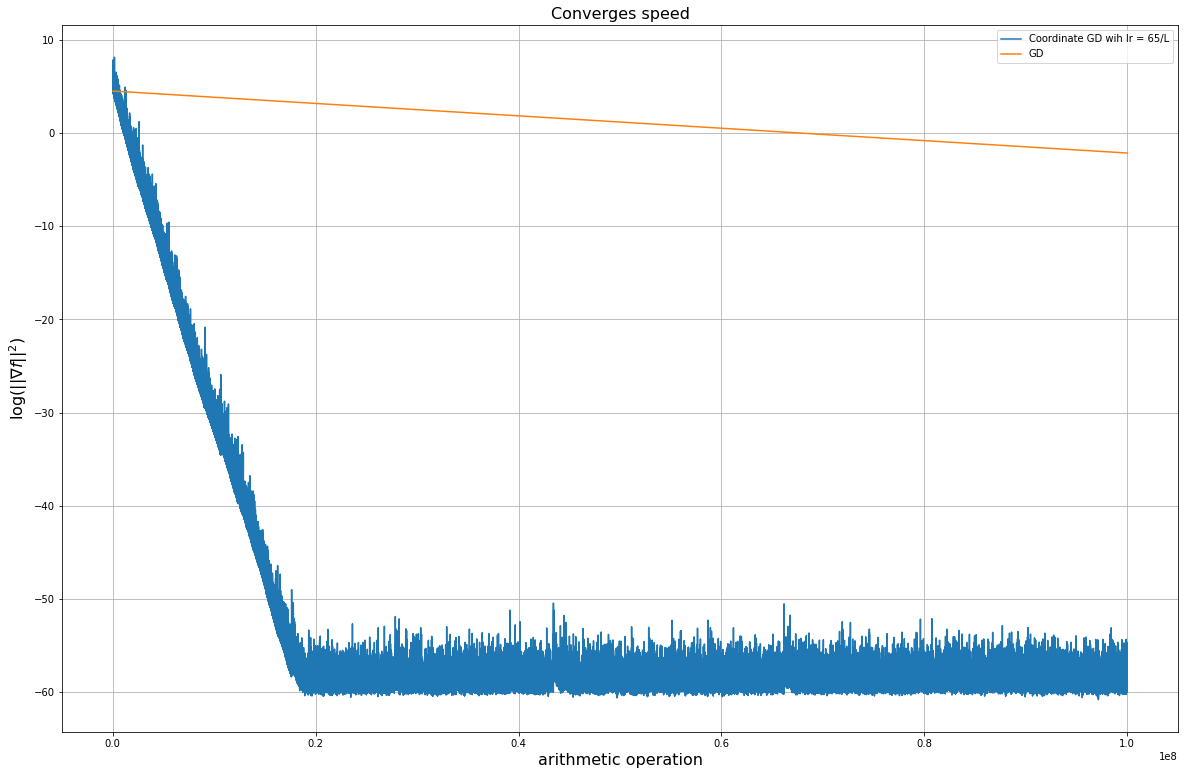

In [16]:
plt.figure(figsize=(20,13))  
plt.plot(cgd.arithmetic_history, np.log(cgd.grad_history), label = 'Coordinate GD wih lr = 65/L') 
plt.plot(gd.arithmetic_history, np.log(gd.grad_history), label = 'GD') 
plt.title('Converges speed', fontsize=16) 
plt.xlabel('arithmetic operation', fontsize=16) 
plt.ylabel(r"log($||\nabla f ||^{2})$", fontsize=16) 
plt.legend() 
plt.grid() 
plt.show() 

__(б)__ В координатном спуске можно брать несколько координат вместо одной. Модифицируйте координнатный спуск, исходя из этого, пробуя разное число координат $b = 1, 5, 10, 20$, а также разные способы сэмплирования: все координатны независимо или зависимо, чтобы не было повторений в батче. Постройте графики аналогичные пункту (а). Сделайте вывод.

In [17]:
class CoordinateDescent: 
    def __init__(self, b, batch_size, max_iter = 10000, L = 1000, mu = 1, d = 100): 
        self.L = L 
        self.mu = mu 
        self.d = d  
        self.grad_history = []  
        self.arithmetic_history = [] 
        self.x = None 
        self.A = generate_matrix(d, mu, L) 
        self.b = b 
        self.alpha = 65/(L * batch_size)
        self.max_iter = max_iter   
        self.count = 0  
        self.batch_size = batch_size 
        
    #на одну итерацию по batch_size тратим - 3 * d + 1 
    def grad(self): 
        g = np.zeros((self.d,)) 
        a = random.sample(range(0, self.d), self.batch_size) 
        for index in a: 
            g[index] = 1/2 * np.dot(np.reshape(self.A[index] + self.A.T[index], (1, self.d)), self.x) - self.b[index]  
        return g  
    
    def full_grad(self): 
        return 1/2 * np.dot((self.A + self.A.T), self.x) - self.b 
        
    def fit(self):  
        self.x = np.zeros(self.d) 
        for i in range(self.batch_size * (3 * self.d + 1), int(10e7), self.batch_size * (3 * self.d + 1)): 
            g = self.grad()  
            g_full = self.full_grad() 
            self.x = self.x - self.alpha * g  
            self.grad_history.append(np.linalg.norm(g_full)**2)   
            self.arithmetic_history.append(i) 

In [18]:
cgd_1 = CoordinateDescent(b, 1)  
cgd_5 = CoordinateDescent(b, 5) 
cgd_10 = CoordinateDescent(b, 10) 
cgd_20 = CoordinateDescent(b, 20)  

In [19]:
cgd_1.fit() 
cgd_5.fit() 
cgd_10.fit() 
cgd_20.fit()

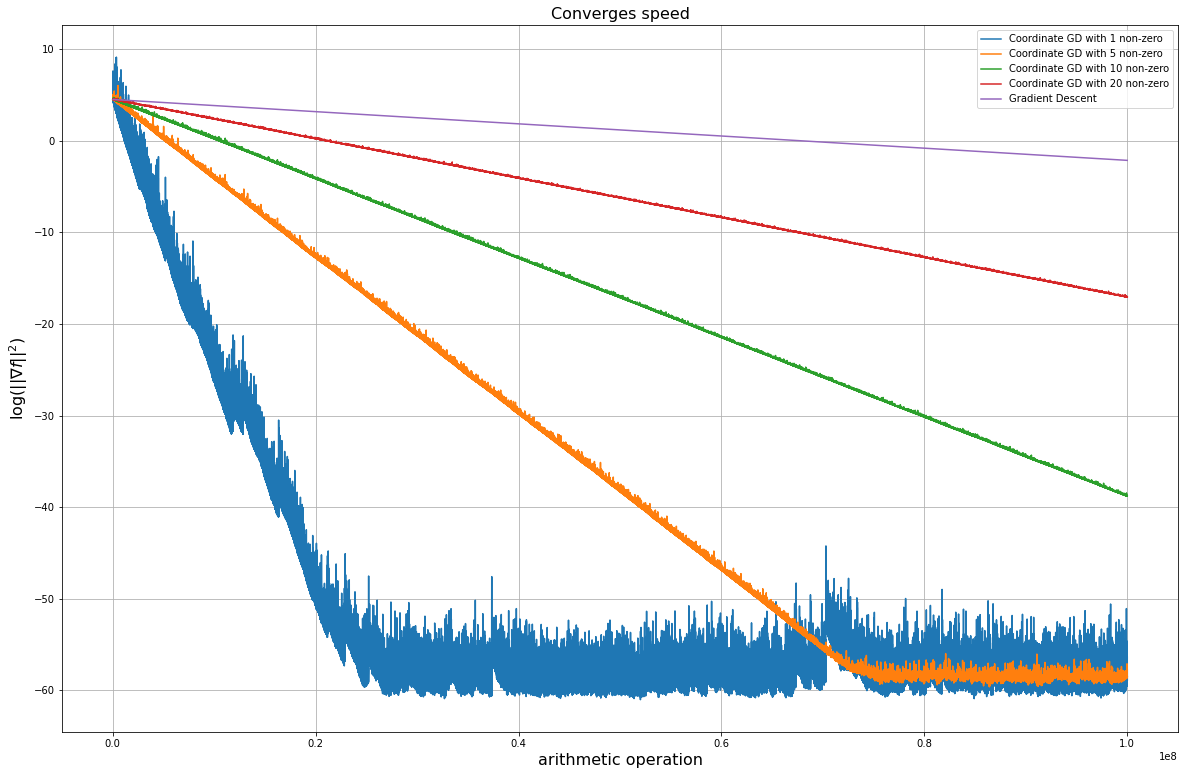

In [20]:
plt.figure(figsize=(20,13))  
plt.plot(cgd_1.arithmetic_history, np.log(cgd_1.grad_history), label = 'Coordinate GD with 1 non-zero') 
plt.plot(cgd_5.arithmetic_history, np.log(cgd_5.grad_history), label = 'Coordinate GD with 5 non-zero')
plt.plot(cgd_10.arithmetic_history, np.log(cgd_10.grad_history), label = 'Coordinate GD with 10 non-zero')
plt.plot(cgd_20.arithmetic_history, np.log(cgd_20.grad_history), label = 'Coordinate GD with 20 non-zero') 
plt.plot(gd.arithmetic_history, np.log(gd.grad_history), label = 'Gradient Descent')
plt.title('Converges speed', fontsize=16) 
plt.xlabel('arithmetic operation', fontsize=16) 
plt.ylabel(r"log($||\nabla f ||^{2})$", fontsize=16) 
plt.legend() 
plt.grid() 
plt.show() 


Вывод можно сделать следующий: чем меньше мы берем b(количество ненулевых координат), тем быстрее(в количестве
арифметических операций) в среднем сходится координатный спуск, но тем больше дисперсия такого решения.  
Также бинарным поиском  нашли примерную константу с которой все сходиться слишком хорошо


## Задача 2

Рассмотрим задачу линейной регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. 

In [21]:
dataset = "mushrooms.txt" 

In [22]:
from sklearn.datasets import load_svmlight_file 
from sklearn.model_selection import train_test_split 

data = load_svmlight_file(dataset)  
X, y = data[0].toarray(), data[1]  

n, d = X.shape

p = np.random.permutation(n) 

X = X[p] 
y = y[p] 

y = 2 * y - 3  
print(n, d)

8124 112


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print(X_train.shape)

(6499, 112)


In [24]:
from numpy import linalg  

w, v = np.linalg.eig(2 * np.dot(X_train.T, X_train)) 
print('L is equal to', max(w)) 
L = max(w) 
u, v = np.linalg.eig(2 * np.dot(X_train.T, X_train) + 2 * L/1000 * np.eye(d))
print('Mu is equal to', min(u)) 

L is equal to (134704.36070621692+0j)
Mu is equal to (269.4087214124332-1.4210854715202004e-14j)


In [25]:
#зафиксировали вот полученное L близкое к оптимальному, теперь  найдем mu 
# в этой домашней работе я наконец-то сделал грамотнее и теперь mu не ноль

__(б)__ Реализуйте координатный SGD, SEGA для задачи линейно регрессии. Каким будете брать $b$? Как будете выбирать шаг и другие параметры методов?

In [26]:
reg = L/1000

In [27]:
#количество операций на подсчет одного градиента = 
#(2d - 1) * n + n + 2n - 1 = (2d - 1) * n + 3n - 1  = (2d + 2) * n - 1 = 2(d + 1) * n - 1 
def grad(a, X, y, w): 
    g = np.zeros((d,))
    for index in a:  
        g[index] = 2 * np.dot(X.T[index], (np.dot(X, w) - y))   
        g[index] = g[index] + 2 * reg * w[index]
    return g 
# на одну операцию уходит n * (2d - 1) + n + d * (2n - 1)
def full_grad(X, y, w): 
    return (2 * np.dot(X.T, (np.dot(X, w) - y)) + 2 * reg * w)

In [28]:
class coordinate_SGD: 
    def __init__(self, b, lr): 
        self.b = b 
        self.lr = lr 
        self.w = None  
        self.arithmetic_history = [] 
        self.grad_history = [] 
        self.time_history = []  
        self.weights_history = [] 
        self.n = None
    
    def fit(self, X, y): 
        time_start = time.time() 
        self.w = np.zeros(d)
        self.n = X.shape[0]
        for i in range(self.b * (2 * (d + 1) * self.n - 1), int(2 * 10e10), self.b * (2 * (d + 1) * self.n - 1)):  
            a = random.sample(range(d), self.b) 
            g = grad(a, X, y, self.w)  
            g_full = full_grad(X, y, self.w) 
            self.w = self.w - self.lr * g 
            self.grad_history.append(np.linalg.norm(g_full)**2) 
            self.arithmetic_history.append(i)  
            self.time_history.append(time.time() - time_start) 
            self.weights_history.append(self.w)

    def predict(self, X, w): 
        y_predicted = np.dot(X, w) 
        for i in range(len(y_predicted)): 
            if(y_predicted[i] >= 0):
                y_predicted[i] = 1 
            else: 
                y_predicted[i] = -1 
        return y_predicted 

In [78]:
class SEGA: 
    def __init__(self, b, lr): 
        self.b = b 
        self.lr = lr 
        self.w = None 
        self.arithmetic_history = [] 
        self.grad_history = [] 
        self.time_history = [] 
        self.weights_history = [] 
        self.n = None 
    def fit(self, X, y): 
        time_start = time.time() 
        self.w = np.zeros(d) 
        self.n = X.shape[0] 
    
        r = np.zeros(d)
        #это стоит: (2d - 1) * n + n + (2n - 1) *d 
        for i in range(self.b * (2 * (d + 1) * self.n - 1) + self.b,
                       int(2 * 10e10), self.b * (2 * (d + 1) * self.n - 1) + self.b):  
            a = random.sample(range(0, d), self.b) 
            r[a] = 0 
            g = grad(a, X, y, self.w) 
            g_full = full_grad(X, y, self.w) 
            r = r + g 
            self.w = self.w - self.lr * r  
            self.grad_history.append(np.linalg.norm(g_full)**2) 
            self.time_history.append(time.time() - time_start) 
            self.arithmetic_history.append(i) 
            self.weights_history.append(self.w) 
        
    def predict(self, X, w): 
        y_predicted = np.dot(X, w) 
        for i in range(len(y_predicted)): 
            if(y_predicted[i] >= 0): 
                y_predicted[i] = 1 
            else: 
                y_predicted[i] = -1 
        return y_predicted

In [30]:
csgd = coordinate_SGD(1, 20/L)

In [31]:
csgd.fit(X_train, y_train)

/tmp/ipykernel_509959/1840068990.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  g[index] = g[index] + 2 * reg * w[index]
/tmp/ipykernel_509959/1840068990.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  g[index] = 2 * np.dot(X.T[index], (np.dot(X, w) - y))


In [79]:
sega = SEGA(1, 1/(6 * L))

In [80]:
sega.fit(X_train, y_train)

/tmp/ipykernel_509959/1840068990.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  g[index] = g[index] + 2 * reg * w[index]
/tmp/ipykernel_509959/1840068990.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  g[index] = 2 * np.dot(X.T[index], (np.dot(X, w) - y))


In [81]:
def accuracy(y_predicted, y): 
    return np.sum(y_predicted == y) / len(y) 

In [ ]:
csgd_accuracy_history = [] 
for w in csgd.weights_history: 
    y_predicted = csgd.predict(X_test, w) 
    csgd_accuracy_history.append(accuracy(y_predicted, y_test)) 

In [82]:
sega_accuracy_history = [] 
for w in sega.weights_history: 
    y_predicted = sega.predict(X_test, w) 
    sega_accuracy_history.append(accuracy(y_predicted, y_test))

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество арифметических операций, по оси $y$ - $\|\nabla f(x^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

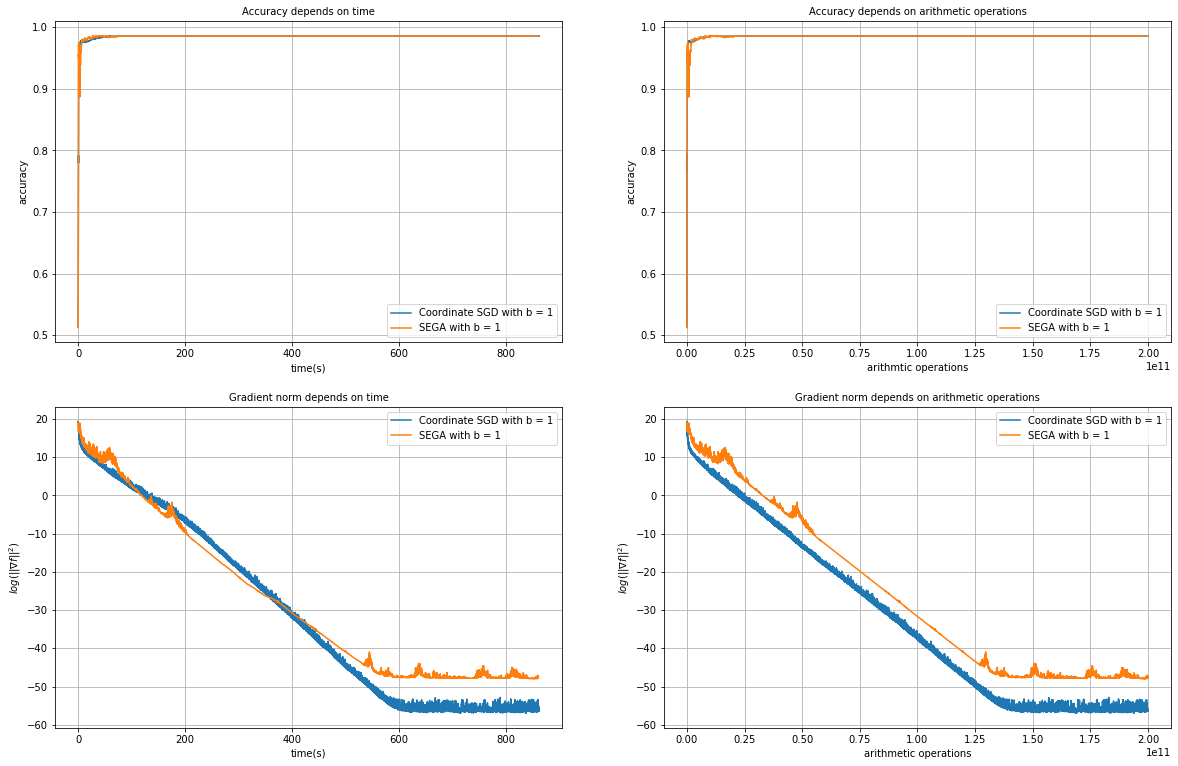

In [84]:
#ответ 
fig, ax = plt.subplots(2, 2, figsize=(20, 13))  
ax[0][0].grid() 
ax[1][1].grid() 
ax[0][1].grid() 
ax[1][0].grid()  
ax[0][0].set_title('Accuracy depends on time', fontsize=10) 
ax[0][1].set_title('Accuracy depends on arithmetic operations', fontsize=10) 
ax[1][0].set_title('Gradient norm depends on time', fontsize=10) 
ax[1][1].set_title('Gradient norm depends on arithmetic operations', fontsize=10) 
ax[0][0].set_xlabel('time(s)', fontsize=10) 
ax[0][0].set_ylabel('accuracy', fontsize=10) 
ax[1][0].set_xlabel('time(s)', fontsize=10) 
ax[0][1].set_ylabel('accuracy', fontsize=10)  
ax[1][0].set_ylabel(r"$log(||\nabla f||^{2})$", fontsize=10) 
ax[1][1].set_ylabel(r"$log(||\nabla f||^{2})$", fontsize=10) 
ax[0][1].set_xlabel('arithmtic operations', fontsize=10) 
ax[1][1].set_xlabel('arithmetic operations', fontsize=10)  

ax[1][0].plot(csgd.time_history, np.log(csgd.grad_history), label='Coordinate SGD with b = 1') 
ax[1][0].plot(sega.time_history, np.log(sega.grad_history), label='SEGA with b = 1')  
ax[1][0].legend() 
ax[0][1].plot(csgd.arithmetic_history, csgd_accuracy_history, label='Coordinate SGD with b = 1') 
ax[0][1].plot(sega.arithmetic_history, sega_accuracy_history, label='SEGA with b = 1')
ax[0][1].legend() 
ax[0][0].plot(csgd.time_history, csgd_accuracy_history, label='Coordinate SGD with b = 1') 
ax[0][0].plot(sega.time_history, sega_accuracy_history, label='SEGA with b = 1') 
ax[0][0].legend() 
ax[1][1].plot(csgd.arithmetic_history, np.log(csgd.grad_history), label='Coordinate SGD with b = 1')
ax[1][1].plot(sega.arithmetic_history, np.log(sega.grad_history), label='SEGA with b = 1') 
ax[1][1].legend()  

Лучше не выходит, не знаю по какой причине. Константу обучения подбираем бинарным поиском. Количество координат лучше выбирать маленьким для скорейшего спуска.

__Бонусные пункты__

__(г)__ Попробуйте объеденить подходы SAGA/SVRG/L-SVRG и координатный SGD/SEGA (т.е. могут получиться пары SAGA + координатный, SVRG + SEGA и еще четыре других). Вам достаточно выбрать одну пару. Как при этом будет выглядеть итерация метода (запишите в явном виде)? Докажите сходимость данного подхода для $\mu$-сильно выпуклой $f$ и $L$-гладкой $f_i$.

In [635]:
#ответ

__(д)__ Реализуйте новый метод. Сравните его с двумя методами, которые были взяты за базу, на задаче линейной регресии. Способы сравнения методов придумайте самостоятельно. Сделайте вывод.

In [ ]:
#ответ